In [376]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [377]:
ticker = "BILI"
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
data = pdr.get_data_yahoo(ticker, start, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-03-28,11.260000,9.620000,9.800000,11.240000,23929600,11.240000
2018-03-29,11.800000,10.650000,11.500000,11.000000,5863900,11.000000
2018-04-02,11.500000,10.910000,11.050000,11.000000,2771000,11.000000
2018-04-03,11.500000,10.791000,11.500000,10.910000,2509600,10.910000
2018-04-04,11.080000,10.550000,10.750000,10.970000,1498200,10.970000
...,...,...,...,...,...,...
2022-07-12,24.790001,23.680000,24.299999,24.250000,3504500,24.250000
2022-07-13,25.020000,23.740000,23.780001,24.620001,4185000,24.620001
2022-07-14,24.219999,22.709999,23.969999,23.090000,6254600,23.090000


- Calculating the diff of Adj Close to figure out which day is positive and which day is negative

In [378]:
delta = data["Adj Close"].diff(1)
delta.dropna(inplace = True)
delta

Date
2018-03-29   -0.240000
2018-04-02    0.000000
2018-04-03   -0.090000
2018-04-04    0.060000
2018-04-05    0.009999
                ...   
2022-07-12    0.139999
2022-07-13    0.370001
2022-07-14   -1.530001
2022-07-15   -0.210001
2022-07-18    1.550001
Name: Adj Close, Length: 1083, dtype: float64

In [379]:
positive = delta.copy() #.copy() is "Deep copy". So later the change of delta will not affect positive. Directly = just point to the object.
negative = delta.copy()
positive[positive < 0] = 0 #For series, we can use series_name[series_name < 0] = 0 to finish the job. series_name in [series_name<0] is a Series Name but represents each individuals in the Series in the critiria section.
negative[negative > 0] = 0
days = 14

In [380]:
average_gain = positive.rolling(window = days).mean()
average_loss = abs(negative.rolling(window = days).mean())
relative_strength = average_gain / average_loss
RSI = 100.0-(100.0/(1.0+relative_strength))

In [381]:
combined = pd.DataFrame() #Establish a void DataFrame in order and then insert columns
combined['Adj Close'] = data['Adj Close'] #df["name"] = pd.Series to add a new column
combined['RSI'] = RSI
combined

,Adj Close,RSI
Date,,
2018-03-28,11.240000,NaN
2018-03-29,11.000000,NaN
2018-04-02,11.000000,NaN
2018-04-03,10.910000,NaN
2018-04-04,10.970000,NaN
...,...,...
2022-07-12,24.250000,38.725151
2022-07-13,24.620001,42.969310
2022-07-14,23.090000,33.333333


Text(0.5, 1.0, 'RSI Value')

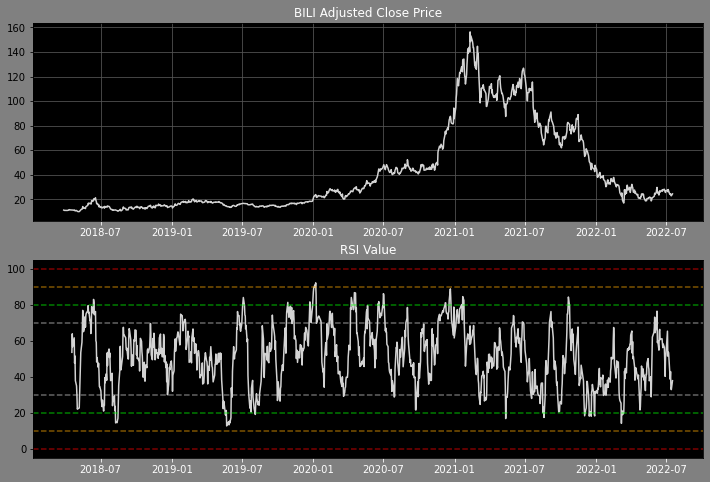

In [382]:
plt.figure(figsize=(12, 8)) #Define figsize
ax1 = plt.subplot(211)
ax1.plot(combined['Adj Close'].index, combined['Adj Close'], color = "lightgrey")
ax1.set_title(f"{ticker} Adjusted Close Price", color = "white")
ax1.grid(True, color = "#555555")
ax1.set_axisbelow(True)
ax1.set_facecolor('black')#Set the plotting area background color as black
ax1.figure.set_facecolor('grey')#Set the figure background color as grey
ax1.tick_params(axis = 'x', colors = 'white')#Set x-axis color as white

ax2 = plt.subplot(212, sharex =  ax1) #sharex let ax1 and ax2 share the same x-axis.
ax2.plot(combined['RSI'].index, combined['RSI'], color = 'lightgrey')
ax2.axhline(0, linestyle = '--', alpha = 0.5, color = '#ff0000')
ax2.axhline(10, linestyle = '--', alpha = 0.5, color = '#ffaa00')
ax2.axhline(20, linestyle = '--', alpha = 0.5, color = '#00ff00')
ax2.axhline(30, linestyle = '--', alpha = 0.5, color = '#cccccc')

ax2.axhline(70, linestyle = '--', alpha = 0.5, color = '#cccccc')
ax2.axhline(80, linestyle = '--', alpha = 0.5, color = '#00ff00')
ax2.axhline(90, linestyle = '--', alpha = 0.5, color = '#ffaa00')
ax2.axhline(100, linestyle = '--', alpha = 0.5, color = '#ff0000')


ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor('black')#Set the plotting area background color as black
ax2.figure.set_facecolor('grey')#Set the figure background color as grey
ax2.tick_params(axis = 'x', colors = 'white')#Set x-axis color as white
ax2.set_title('RSI Value', color = "white")

In [383]:
combined['RSI'] = combined['RSI'].shift(1)

In [384]:
combined['condition'] = np.where(combined['RSI']<30, 1, 0)
combined['condition'] = np.where(combined['RSI']>70, -1, combined['condition'])
combined['condition'] = combined['condition'].diff()


signal = [0]
flag = 0
for i in range(len(combined)):

    if flag == 1 and combined['condition'][i] == -1.0 and combined['RSI'][i] > 70:
        signal.append(0)
        flag = 0

    elif flag == 0 and combined['condition'][i] == 1.0 and combined['RSI'][i] < 30:
        signal.append(1)
        flag = 1

    else:
        signal.append(signal[i])

signal.pop(0)
combined['signal'] = signal

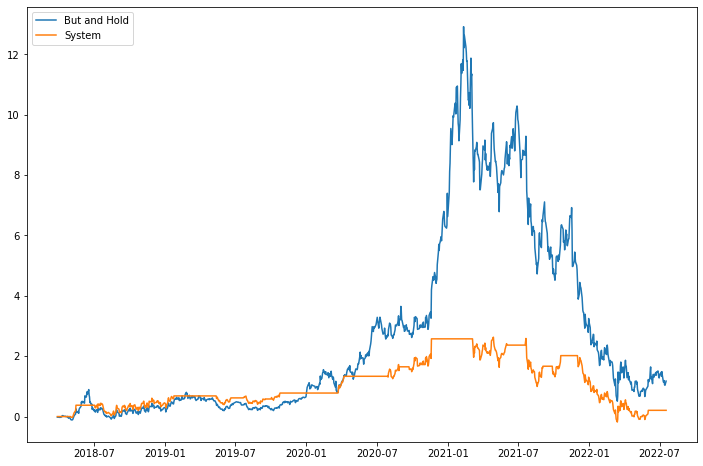

In [385]:
combined['return'] = np.log(combined["Adj Close"]).diff()
combined['system_return'] = combined['return'] * combined['signal']
plt.figure(figsize=(12,8))
plt.plot(np.exp(combined['return']).cumprod()-1, label = "But and Hold")
plt.plot(np.exp(combined['system_return']).cumprod()-1, label = "System")
plt.legend(loc = 2)


In [386]:
combined[60:80]

,Adj Close,RSI,condition,signal,return,system_return
Date,,,,,,
2018-06-22,16.65,48.310571,0.0,0,0.012693,0.000000
2018-06-25,15.36,50.806449,0.0,0,-0.080643,-0.000000
2018-06-26,15.85,45.392494,0.0,0,0.031403,0.000000
2018-06-27,13.90,47.600003,0.0,0,-0.131281,-0.000000
2018-06-28,14.50,43.012051,0.0,0,0.042260,0.000000
2018-06-29,13.99,34.623359,0.0,0,-0.035806,-0.000000
2018-07-02,13.36,34.671282,0.0,0,-0.046078,-0.000000
2018-07-03,13.80,32.142860,0.0,0,0.032403,0.000000
2018-07-05,12.90,27.397268,1.0,1,-0.067441,-0.067441
